# Exercício de fixação de conceitos 1

## Objetivo

O objetivo desse Jupyter Notebook é exercitar conceitos de Aprendizado de Máquina ligados essencialmente à Regressão Linear, dentre eles:

- Cross Validation
- K-fold
- Critério de Root Mean Square Error (RMSE)
- Regressor Linear ótimo em forma fechada

## Problema abordado

O problema a ser trabalhado consite em predizer o número de manchas solares em uma série temporal. O datasheet fornecido contém dados diários de manchas solares desde o ano de 1749 até 2019.

## Visualização dos dados


In [15]:
import pandas as pd
import math
import numpy as np
from numpy import genfromtxt
from numpy import linalg
import matplotlib.pyplot as plt 
from scipy.linalg import toeplitz
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

In [2]:
manchas = genfromtxt('monthly-sunspots.csv', delimiter=',')

In [3]:
manchas.shape

(3253, 3)

Retirando as colunas de índice e data.

In [4]:
manchas = np.delete(manchas,np.s_[0:2],axis=1)
manchas = np.delete(manchas,0,axis=0)

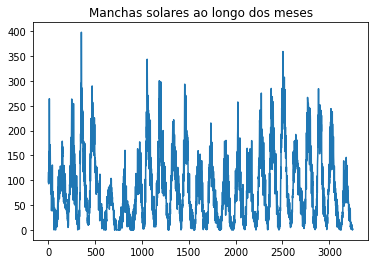

In [5]:
plt.plot(manchas)
plt.title("Manchas solares ao longo dos meses")
plt.show()

## Parte 1 

Montagem da matriz de entrada e do vetor de saídas esperadas



In [73]:
K = 24
X = toeplitz(manchas[::-1]) # matriz de entrada
y = manchas[K:] # vetor de saída
N = len(y)
print(X)

[[  1.6   0.5   0.4 ... 116.7 104.3  96.7]
 [  0.5   1.6   0.5 ...  92.8 116.7 104.3]
 [  0.4   0.5   1.6 ... 141.7  92.8 116.7]
 ...
 [116.7  92.8 141.7 ...   1.6   0.5   0.4]
 [104.3 116.7  92.8 ...   0.5   1.6   0.5]
 [ 96.7 104.3 116.7 ...   0.4   0.5   1.6]]


In [74]:
XL = X[:,:K]
XL = XL[::-1]
XL = XL[:-K]
XL

array([[ 96.7, 104.3, 116.7, ..., 109.5, 105.5, 125.7],
       [104.3, 116.7,  92.8, ..., 105.5, 125.7, 116.7],
       [116.7,  92.8, 141.7, ..., 125.7, 116.7,  72.5],
       ...,
       [ 13.2,   5.7,   8.2, ...,   0.9,   0.5,   1.1],
       [  5.7,   8.2,   6.8, ...,   0.5,   1.1,   0.4],
       [  8.2,   6.8,  10.7, ...,   1.1,   0.4,   0.5]])

Divisão dos dados em grupo de treinamento e grupo de teste (5 anos ou 120 meses).

In [75]:
Xtest = XL[-120:,:]
ytest = y[-120:,:]
Xtrain = XL[:-120,:]
ytrain = y[:-120,:]

In [77]:
def rmse(predictions, targets):
    return np.sqrt(np.mean((predictions-targets)**2))

1

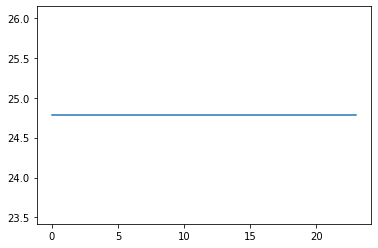

In [78]:
n_splits_kfold = 4
k_max = 24
kf = KFold(n_splits = n_splits_kfold)

rmse_vec = np.zeros(k_max)
for k in range(k_max):
    Xtrain_kfold = Xtrain[:,:(k + 1)]
    
    rmse_acc = 0

    for train_index, test_index in kf.split(Xtrain_kfold):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train_kfold, X_test_kfold = Xtrain[train_index], Xtrain[test_index]
        y_train_kfold, y_test_kfold = ytrain[train_index], ytrain[test_index]
        
        reg = LinearRegression(fit_intercept=True).fit(X_train_kfold, y_train_kfold)
        ypred_kfold = reg.predict(X_test_kfold)
        rmse_acc += rmse(y_test_kfold, ypred_kfold)
        
    rmse_vec[k] = rmse_acc/4

plt.plot(rmse_vec)

best_k = rmse_vec.argmin() + 1
best_k




In [56]:
k = 3
XL[:,:-k]

array([[109.5, 105.5, 125.7],
       [105.5, 125.7, 116.7],
       [125.7, 116.7,  72.5],
       ...,
       [  0.9,   0.5,   1.1],
       [  0.5,   1.1,   0.4],
       [  1.1,   0.4,   0.5]])

Separação dos dados nos grupos de treinamento e teste.

In [80]:
Xteste = XL[-120:,:]
yteste = y[-120:,:]
Xtreino = XL[:-120,:]
ytreino = y[:-120,:]

13.717715306600654


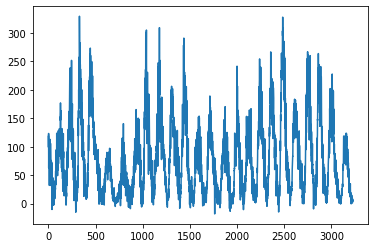

In [94]:
reg = LinearRegression(fit_intercept=True).fit(Xteste, yteste)
est = reg.predict(Xteste)
err = rmse(est,yteste)
print(err)
plt.plot(reg.predict(XL))

In [93]:
reg = LinearRegression(fit_intercept=True).fit(Xteste, yteste)
est = reg.predict(Xteste)
err = rmse(est,ytrain)
print(err)
plt.plot(reg.predict(XL)

SyntaxError: unexpected EOF while parsing (<ipython-input-93-cd5538dd038b>, line 5)

In [12]:
print(manchas)


[[ 96.7]
 [104.3]
 [116.7]
 ...
 [  0.4]
 [  0.5]
 [  1.6]]


(3249, 3249)